In [5]:
using Revise
using PyPlot
using Infiltrator
using LinearAlgebra
using Bem2d
using PyCall

include("Helpers.jl")

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /root/.julia/packages/Revise/lwch5/src/Revise.jl:866


twopanel (generic function with 1 method)

In [6]:
mu = 30e9
lambda = 30e9
nu = 0.25
g = 9.81
rho = 2700
alpha = 1e-7 # scalar preconditioner
npts = 100
offset = 1
B = -20e3 # Bottom
R = 20e3 # Right
T = 0e3 # Top
L = -20e3 # Left

-20000.0

In [7]:
# Element geometries and data structures for the box case
elsbox = Elements(Int(1e5))
nfault = 1
nside = 50

# From thrust fault example
x1T, y1T, x2T, y2T = discretizedline(-20e3, 0, 20e3, 0, nside)
y1T = -1e3 * atan.(x1T / 1e3)
y2T = -1e3 * atan.(x2T / 1e3)
# y1T = zeros(length(y1T))
# y2T = zeros(length(y2T))

xgrid, ygrid = obsgrid(L+offset, B+offset, R-offset, maximum(y1T)-offset, npts)

x1, y1, x2, y2 = discretizedline(L, B, R, B, nside) # Bottom
addelsez!(elsbox, x1, y1, x2, y2, "B")
x1, y1, x2, y2 = discretizedline(R, B, R, minimum(y2T), nside) # Right hand side
addelsez!(elsbox, x1, y1, x2, y2, "R")
addelsez!(elsbox, x1T, y1T, x2T, y2T, "T")
x1, y1, x2, y2 = discretizedline(L, maximum(y1T), L, B, nside) # Left hand side
addelsez!(elsbox, x1, y1, x2, y2, "L")
x1, y1, x2, y2 = discretizedline(-10e3, -10e3, -5e3, -5e3, nfault) # 45 degree dipping fault
addelsez!(elsbox, x1, y1, x2, y2, "F")
idxbox = getidxdict(elsbox);

getidx found 50 elements with label "B"
getidx found 50 elements with label "R"
getidx found 50 elements with label "T"
getidx found 50 elements with label "L"
getidx found 1 elements with label "F"


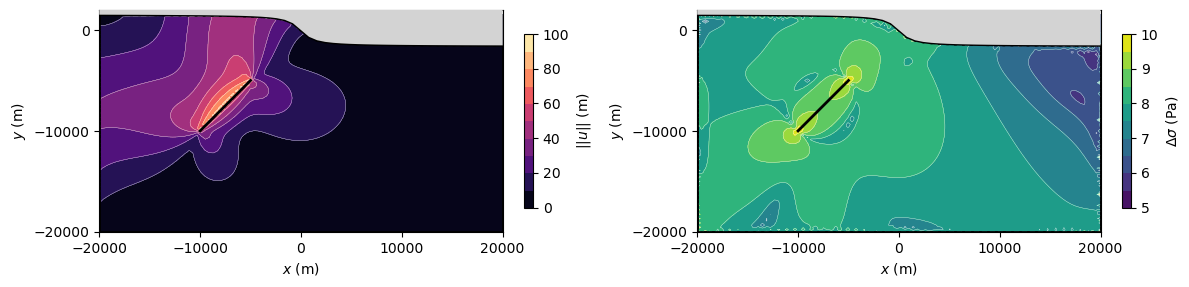

In [8]:
BRTL_idx = [idxbox["B"] ; idxbox["R"] ; idxbox["T"] ; idxbox["L"]]
RTL_idx = [idxbox["R"] ; idxbox["T"] ; idxbox["L"]]
### Fault only
### R, T, L are traction free bcs
### B is zero slip BC
T_TB_F, H_TB_F = PUTC(slip2dispstress, elsbox, BRTL_idx, idxbox["F"], mu, nu)
Fslip = [100; 100]; # y-direction slip only
Uslip = T_TB_F * Fslip
Tslip = H_TB_F * Fslip

# Kernels and solve
T_B_BRTL, H_B_BRTL = PUTC(slip2dispstress, elsbox, idxbox["B"], BRTL_idx, mu, nu)
T_RTL_BRTL, H_RTL_BRTL = PUTC(slip2dispstress, elsbox, RTL_idx, BRTL_idx, mu, nu)
bcsbox = zeros(8 * nside)
bcsbox[1:2*nside] = -Uslip[1:2*nside] # Bottom
bcsbox[2*nside+1:4*nside] = -Tslip[2*nside+1:4*nside] # Right
bcsbox[4*nside+1:6*nside] = -Tslip[4*nside+1:6*nside] # Top
bcsbox[6*nside+1:8*nside] = -Tslip[6*nside+1:8*nside] # Left
THbox = [T_B_BRTL ; H_RTL_BRTL]
Ueffbox = THbox \ bcsbox

# Volume evaluation
UTB, STB = constdispstress(slip2dispstress, xgrid, ygrid, elsbox, BRTL_idx,
                           Ueffbox[1:2:end], Ueffbox[2:2:end], mu, nu)
UF, SF = constdispstress(slip2dispstress, xgrid, ygrid, elsbox, idxbox["F"],
                         Fslip[1:2:end], Fslip[2:2:end], mu, nu)
Ufaultonly = UTB .+ UF
Sfaultonly = STB .+ SF
twopanel(xgrid, ygrid, npts, Ufaultonly, Sfaultonly, idxbox, elsbox);

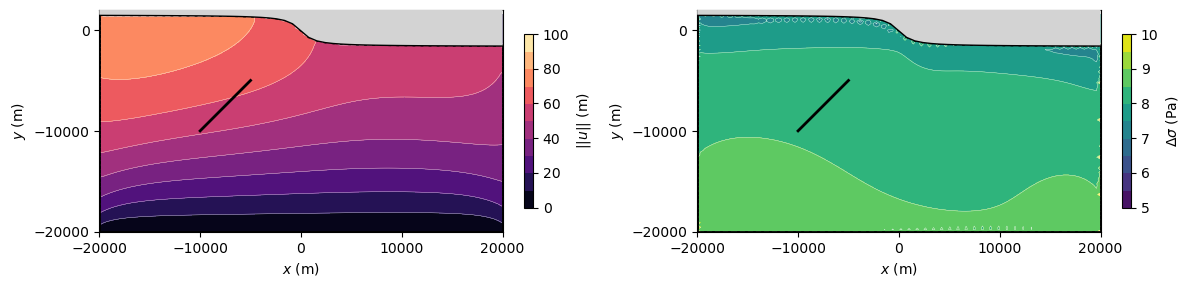

In [9]:
### Box BEM problem (no dislocation, gravity only)
# Displacement BCs for bottom
Ug, Sg = gravityparticularfunctions(elsbox.xcenter[idxbox["B"]],
                                    elsbox.ycenter[idxbox["B"]],
                                    g, rho, lambda, mu)    
bcsboxgravity = zeros(2 * elsbox.endidx - 2)
bcsboxgravity[1:2:2*nside] = Ug[:, 1]
bcsboxgravity[2:2:2*nside] = Ug[:, 2]

# Traction BCs for top and sides
Ug, Sg = gravityparticularfunctions(elsbox.xcenter[idxbox["T"]],
                                    elsbox.ycenter[idxbox["T"]],
                                    g, rho, lambda, mu)  
Ttx = zeros(nside)
Tty = zeros(nside)
for i in 1:length(Sg[:, 1])
    nvec = [elsbox.xnormal[idxbox["T"][i]] ; elsbox.ynormal[idxbox["T"][i]]]
    temp = [Sg[i, 1] Sg[i, 3] ; Sg[i, 3] Sg[i, 2]] * nvec
    Ttx[i] = temp[1]
    Tty[i] = temp[2]
end
bcsboxgravity[4*nside+1:2:6*nside] = Ttx
bcsboxgravity[4*nside+2:2:6*nside] = Tty
bcsboxgravity *= -1
Ueffboxparticular = THbox \ bcsboxgravity  

Ucomp, Scomp = constdispstress(slip2dispstress, xgrid, ygrid, elsbox,
                               [idxbox["B"] ; idxbox["R"] ; idxbox["T"] ; idxbox["L"]],
                               Ueffboxparticular[1:2:end], Ueffboxparticular[2:2:end], mu, nu)
Uint, Sint = gravityparticularfunctions(xgrid, ygrid, g, rho, lambda, mu)
Ugravityonly = @. Ucomp + Uint
Sgravityonly = @. Scomp + Sint
twopanel(xgrid, ygrid, npts, Ugravityonly, Sgravityonly, idxbox, elsbox)

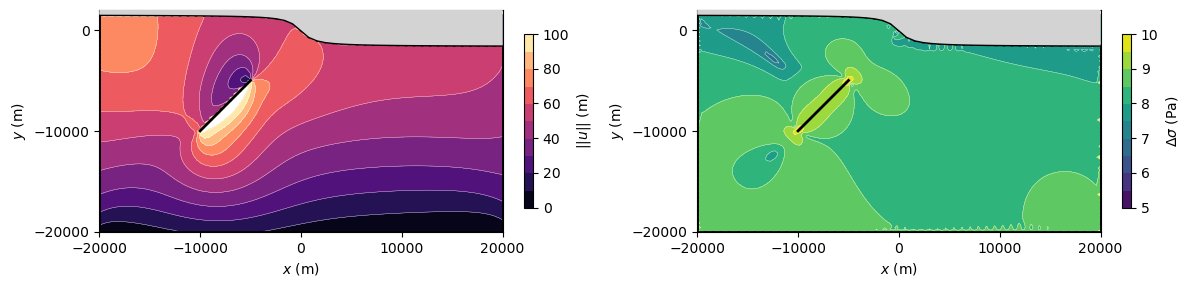

In [10]:
### Box BEM problem (dislocation and gravity)
bcscombined = bcsboxgravity .+ bcsbox    
Ueffcombined = THbox \ bcscombined
Ucomp, Scomp = constdispstress(slip2dispstress, xgrid, ygrid, elsbox,
                               BRTL_idx, Ueffboxparticular[1:2:end], Ueffboxparticular[2:2:end], mu, nu)
Ugravityfault = Ucomp .+ Uint .+ UF
Sgravityfault = Scomp .+ Sint .+ SF
twopanel(xgrid, ygrid, npts, Ugravityfault, Sgravityfault, idxbox, elsbox)

In [12]:
mesh = RectangleMesh(Point((1.5 * L, T + (T - B) * 0.5)), Point((1.5 * R, 1.5 * B)), 100, 100)
V = VectorFunctionSpace(mesh, "P", 1)
f = Constant((0, -rho * g)) # Vector of uniform body force
fenics_u = fenics_solve(V, f)

Solving linear variational problem.


"Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2)), 9)"

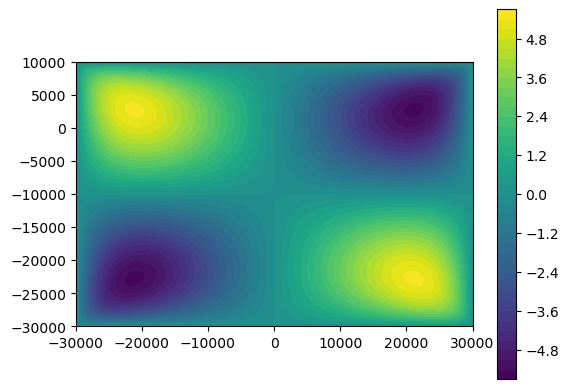

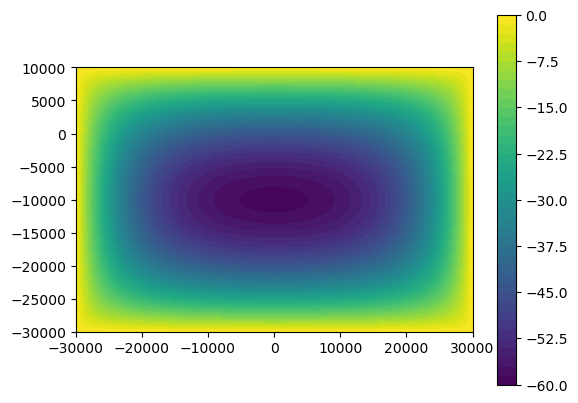

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


In [44]:
py"""
from fenics import *
def FF(x):
    from ufl import nabla_div
    import matplotlib.pyplot as plt
    ux = dot(x,Constant((1.0, 0.0)))
    uy = dot(x,Constant((0.0, 1.0)))
    plt.figure()
    c = plot(ux, colobar=True)
    plt.colorbar(c)
    plt.show()
    plt.figure()
    c = plot(uy, colobar=True)
    plt.colorbar(c)
    plt.show()
"""
py"FF"(fenics_u.pyobject)

In [13]:
sxx_sxy, sxy_syy = fenics_tensor_components(V, fenics_stress(fenics_u, lambda, mu))

("Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2)), 30)", "Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2)), 46)")

In [14]:
bcs_B = -fenics_eval_u(fenics_u, idxbox["B"], elsbox.xcenter, elsbox.ycenter)

450-element Array{Float64,1}:
  5.837999988060731e7 
  1.8196284034191638e8
 -4.0760901232194245e7
  5.635603037535642e7 
  1.7447604154353076e8
 -4.141520484321353e7 
  5.431868849082698e7 
  1.670591112893095e8 
 -4.2076606702413976e7
  5.226727318176435e7 
  1.597016839933734e8 
 -4.273707378213751e7 
  5.020145899131365e7 
  ⋮                   
  5.1114668068812944e7
  1.553800096130553e8 
  4.306242016359764e7 
  5.3501869793714166e7
  1.6388734148885155e8
  4.227470605265215e7 
  5.58682222700253e7  
  1.7250513173865142e8
  4.149866706348598e7 
  5.821654107050419e7 
  1.8123059427195147e8
  4.073880391573928e7 

In [66]:
bcs_RTL_S = -fenics_eval_s(sxx_sxy, sxy_syy, RTL_idx, elsbox.xcenter, elsbox.ycenter)
bcs_RTL = stress_to_trac(bcs_RTL_S, RTL_idx, elsbox.xnormal, elsbox.ynormal);

In [67]:
bcsboxgravityfem = zeros(2 * elsbox.endidx - 2)
bcsboxgravityfem[1:2*nside] = bcs_B
bcsboxgravityfem[2*nside+1:end] = bcs_RTL;

In [68]:
Ueffboxparticular = THbox \ bcsboxgravityfem 
Ubox, Sbox = constdispstress(slip2dispstress, xgrid, ygrid, elsbox,
                               BRTL_idx, Ueffboxparticular[1:2:end], Ueffboxparticular[2:2:end], mu, nu);

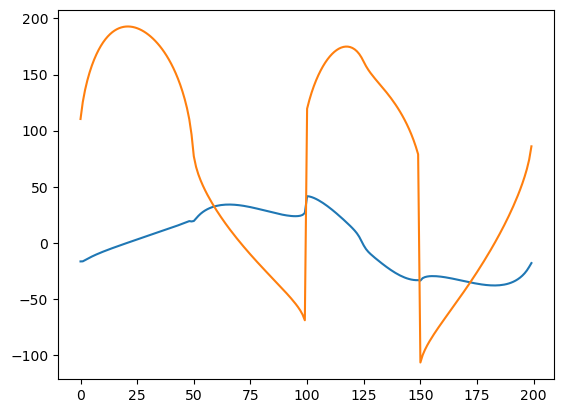

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff26e6f9f40>

In [72]:
plot(Ueffboxparticular[1:2:end])
plot(Ueffboxparticular[2:2:end])

In [75]:
n = length(xgrid)
Ufem = transpose(reshape(fenics_eval_u(fenics_u, 1:n, xgrid, ygrid), (2,:)))
Sfem = transpose(reshape(fenics_eval_s(sxx_sxy, sxy_syy, 1:n, xgrid, ygrid), (3,:)))
Ufem_gravity_only = Ubox + Ufem
Sfem_gravity_only = Sbox + Sfem

10000×3 Array{Float64,2}:
  9.40384e9  -1.55183e11  -4.712e8  
 -1.54756e8  -6.12559e8   -2.59752e8
 -1.0463e10  -1.13767e10  -1.35714e9
 -2.49695e8  -5.98164e8   -1.25192e8
 -4.09696e9  -4.57769e9   -7.40756e8
 -2.39728e8  -5.6731e8    -1.06383e8
 -2.34059e9  -2.7228e9    -4.65899e8
 -2.27941e8  -5.50511e8   -9.22658e7
 -1.57554e9  -1.92694e9   -3.32841e8
 -2.19539e8  -5.41584e8   -8.03287e7
 -1.15961e9  -1.49915e9   -2.56266e8
 -2.13797e8  -5.36768e8   -7.01199e7
 -9.00503e8  -1.23499e9   -2.05224e8
  ⋮                                 
  5.1375e7    1.04826e8   -5.34084e7
  5.70774e7   1.09754e8   -5.9387e7 
  6.27041e7   1.16106e8   -6.61179e7
  6.80023e7   1.24256e8   -7.36122e7
  7.26535e7   1.34604e8   -8.1748e7 
  7.61949e7   1.47823e8   -9.02827e7
  7.80891e7   1.64403e8   -9.87025e7
  7.78715e7   1.84535e8   -1.06095e8
  7.5242e7    2.08209e8   -1.11247e8
  7.03864e7   2.34425e8   -1.12764e8
  6.4222e7    2.61076e8   -1.0943e8 
  5.81343e7   2.85727e8   -1.00918e8

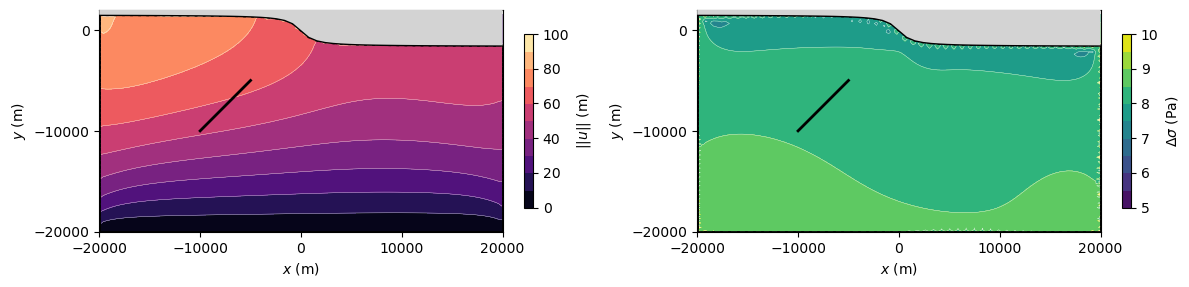

In [77]:
twopanel(xgrid, ygrid, npts, Ufem_gravity_only, Sfem_gravity_only, idxbox, elsbox);

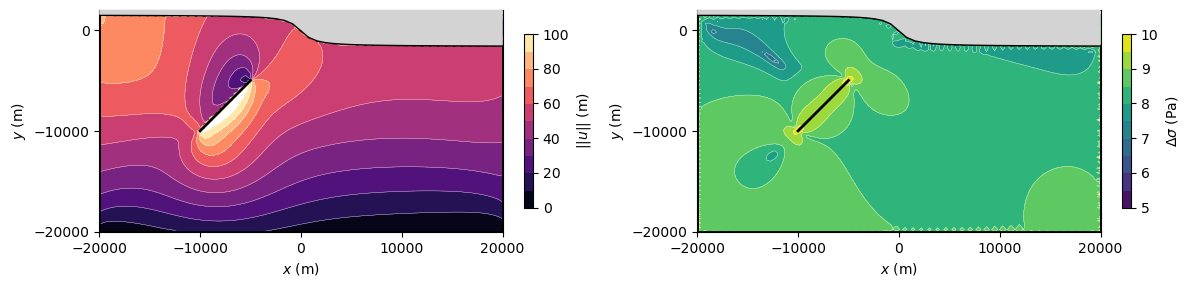

In [78]:
### Box BEM problem (dislocation and gravity)
bcscombined = bcsboxgravityfem .+ bcsbox    
Ueffcombined = THbox \ bcscombined
Ucomp, Scomp = constdispstress(slip2dispstress, xgrid, ygrid, elsbox,
                               [idxbox["B"] ; idxbox["R"] ; idxbox["T"] ; idxbox["L"]],
                               Ueffboxparticular[1:2:end], Ueffboxparticular[2:2:end], mu, nu)
Ugravityfault = Ucomp .+ Ufem .+ UF
Sgravityfault = Scomp .+ Sfem .+ SF
twopanel(xgrid, ygrid, npts, Ugravityfault, Sgravityfault, idxbox, elsbox)